In [9]:
import os
import sys
from sys import path
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
from scipy.optimize import least_squares
import json
import coord_helper as ch
import random
import h5py
import scripts.xcorr.helper as h

BDC is using numpy


STANDARDIZED INITIAL VARBS

In [2]:
config_file_name = 'config_mars_2024_day2.json'
baseline_idx = 1

In [3]:
with open(f"./config/{config_file_name}", "r") as f:
    config = json.load(f)
    dir_parents = []
    coords = []
    # unpack information from the json file
    # Call get_starting_index for all antennas except reference
    for i, (ant, details) in enumerate(config["antennas"].items()):
        if (i == 0) or (i ==baseline_idx):
            coords.append(details['coordinates'])
            dir_parents.append(details["path"])
    global_start_time = config["correlation"]["start_timestamp"]
    end_t = config["correlation"]["end_timestamp"]
    c_acclen = config["correlation"]["coarse_acclen"]
    v_acclen = config["correlation"]["vis_acclen"]
    visibility_window = config["correlation"]["visibility_window"]
    T_SPECTRA = config["correlation"]["point_PFB"] / config["correlation"]["sample_rate"]

print("Antenna Paths:", dir_parents)
print("Antenna Coordinates:", coords)
print("Visibility Accumulation Length", v_acclen)
print("Coarse Accumulation Length:", c_acclen)
print(global_start_time)

Antenna Paths: ['/scratch/s/sievers/mohanagr/mars1_2024/baseband/', '/scratch/s/sievers/mohanagr/mars2_2024/baseband/']
Antenna Coordinates: [[79.41718333333333, -90.76735, 189], [79.41721666666666, -90.75885, 176]]
Visibility Accumulation Length 30000
Coarse Accumulation Length: 1000000
1721900002


In [4]:
ref_coords = coords[0]
a2_coords = coords[1]

ref_path = dir_parents[0]
a2_path = dir_parents[1]

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

context = [global_start_time, visibility_window, [T_SPECTRA, v_acclen, v_nchunks], ref_coords, tle_path]

GET THE SAT PASSES LIST

In [20]:
with open(f"./pulsedata/pulsedata_{global_start_time}_1749048402.json", "r") as f:
    pulsedata = json.load(f)
    
    info = []
    offsets = []
    for pulse_idx, details in enumerate(pulsedata[f"{global_start_time}"]["antenna 1"]):
        #print(f"\n--------pulse idx {pulse_idx}---------")
        start_time = details["start"] * 5
        end_time = details["end"] * 5
        rel = False

        #For now, disregard multiple sat passes. For v2.
        if len(details["sats_present"]) > 1:
            continue

        for satID, values in details["sats_present"].items():
            
            for i in range(len(values)):
                pulse_info = []
                #print(values[i])
                chan = values[i][0]
                corr_offset = values[i][1]
                if values[i][2][0] > 0.9:
                    rel = True
                pulse_info.append([start_time, end_time])
                pulse_info.append(int(satID))
                pulse_info.append(chan)
                pulse_info.append(corr_offset)

                info.append(pulse_info)

        if rel==True:
            offsets.append(details["timestream_offset"])
            
print(info)
print(offsets)
specnumoffset = offsets[0]
print(specnumoffset)
info = info[:22]
print(info)
print(len(info))

[[[2110, 2630], 59051, 1836, 103156], [[2110, 2630], 59051, 1837, 103156], [[6920, 7230], 25338, 1841, 79705], [[8135, 8680], 59051, 1836, 79731], [[8135, 8680], 59051, 1837, 79731], [[12925, 13380], 25338, 1841, 79705], [[13600, 13905], 33591, 1849, 79730], [[13600, 13905], 33591, 1850, 79705], [[14150, 14695], 59051, 1836, 79731], [[14150, 14695], 59051, 1837, 79731], [[14870, 15215], 57166, 1836, 79731], [[14870, 15215], 57166, 1837, 79731], [[17330, 17605], 28654, 1836, 79705], [[17330, 17605], 28654, 1837, 79730], [[18935, 19455], 25338, 1841, 103131], [[19660, 20125], 33591, 1849, 79756], [[19660, 20125], 33591, 1850, 79705], [[20155, 20695], 59051, 1836, 79730], [[20155, 20695], 59051, 1837, 79731], [[20155, 20695], 59051, 1850, 81129], [[20885, 21360], 57166, 1836, 103156], [[20885, 21360], 57166, 1837, 103156], [[26265, 26700], 59051, 1836, 105694], [[26265, 26700], 59051, 1837, 105694], [[26265, 26700], 59051, 1850, 105872], [[26905, 27435], 57166, 1836, 21234], [[26905, 2743

CHECK PULSES ALL AT ONCE

In [25]:
observed_data = []
time_total = time.time()
for pulse_idx in range(len(info)):

    print(f"---------STARTING PULSE {pulse_idx}---------")

    #--------times-----
    relative_start_time = info[pulse_idx][0][0]
    print("Starting correlation, relative to global:", relative_start_time)
    pulse_duration_chunks = int((info[pulse_idx][0][1] - info[pulse_idx][0][0]) / (T_SPECTRA * v_acclen)  )
    print("pulse is this many chunks long", pulse_duration_chunks)
    t_start = global_start_time + relative_start_time
    t_end = t_start + visibility_window


    #----get initialized information----
    files_a1, idx1 = butils.get_init_info(t_start, t_end, ref_path)
    files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)

    #------get corrected offsets-----
    idx_correction = info[pulse_idx][3] - 100000
    if idx_correction>0:
        idx1 = idx1 + idx_correction
    else:
        idx2 = idx2 + np.abs(idx_correction)

    print(idx1-idx2)
    print(info[pulse_idx])

    #-------set up channels-------
    channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
    chanstart = np.where(channels == 1834)[0][0] 
    chanend = np.where(channels == 1852)[0][0]
    nchans=chanend-chanstart

    chan_bigidx = info[pulse_idx][2]
    chanmap = channels[chanstart:chanend].astype(int)
    chan_smallidx = np.where(chanmap == chan_bigidx)[0][0]


    #--------open object----------
    ant1 = bdc.BasebandFileIterator(files_a1, 0, idx1, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')
    ant2 = bdc.BasebandFileIterator(files_a2, 0, idx2, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')


    #--------get visibilities-----
    m1= ant1.spec_num_start
    m2= m1 - specnumoffset
    

    visibility_phased = np.zeros((v_nchunks,len(ant1.channel_idxs)), dtype='complex64')
    time_pulse=time.time()
    #print(f"--------- Processing Pulse Idx {pulse_idx} ---------")
    for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
            xcorr = ch.avg_xcorr_4bit_2ant_float(
                chunk1['pol0'], 
                chunk2['pol0'],
                chunk1['specnums'],
                chunk2['specnums'],
                m1+i*v_acclen,
                m2+i*v_acclen)
            visibility_phased[i,:] = np.sum(xcorr,axis=0)/v_acclen
            #print("CHUNK", i, " has ", xcorr.shape[0], " rows")
    print(f"DONE PULSE {pulse_idx}. TIME:", time.time()-time_pulse)
    visibility_phased = np.ma.masked_invalid(visibility_phased)
    vis_phase = np.angle(visibility_phased)
    obs = np.unwrap(vis_phase[0:pulse_duration_chunks, chan_smallidx])
    observed_data.append(obs)

    break


print("Done with everything. Time taken:", time.time() - time_total)

---------STARTING PULSE 0---------
Starting correlation, relative to global: 2110
pulse is this many chunks long 1057
2261457
[[2110, 2630], 59051, 1836, 103156]
Not reading any data
ACCLEN RECEIVED IS 30000
took 0.199 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17219/1721902074.raw
START SPECNUM IS 3974795990 obj start at 3972473498
ACCLEN RECEIVED IS 30000
took 0.221 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17219/1721902111.raw
START SPECNUM IS 3981020766 obj start at 3980959731
took 1.210 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17219/1721902118.raw
took 1.167 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17219/1721902156.raw
took 0.171 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17219/1721902163.raw
took 0.244 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17219/1721902200.raw
took 0.22

LOOK AT INDIVIDUAL PULSE

catalog #59051 epoch 2024-07-25 21:33:51 UTC


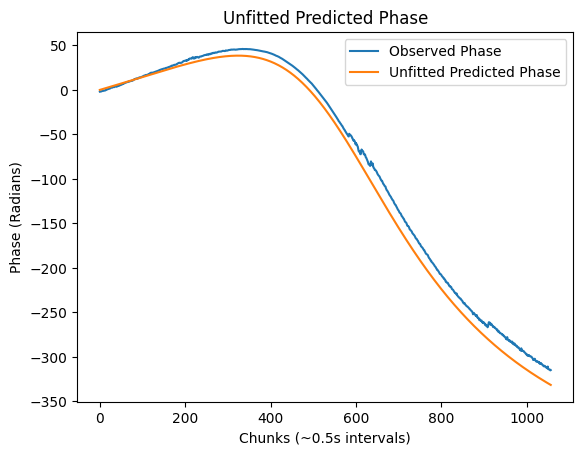

In [26]:
pulse_index = 0
plt.plot(observed_data[0], label="Observed Phase")
plt.plot(ch.phase_pred(a2_coords, pulse_index, info, context), label="Unfitted Predicted Phase")
plt.xlabel("Chunks (~0.5s intervals)")
plt.ylabel("Phase (Radians)")
plt.title("Unfitted Predicted Phase")
plt.legend()

LOOK AT MULTIPLE PULSES

0
catalog #28654 epoch 2024-07-24 20:56:55 UTC
1
catalog #28654 epoch 2024-07-24 20:56:55 UTC
2
catalog #28654 epoch 2024-07-24 20:56:55 UTC
3
catalog #59051 epoch 2024-07-24 21:55:34 UTC
4
catalog #59051 epoch 2024-07-24 21:55:34 UTC
5
catalog #28654 epoch 2024-07-24 20:56:55 UTC
6
catalog #28654 epoch 2024-07-24 20:56:55 UTC


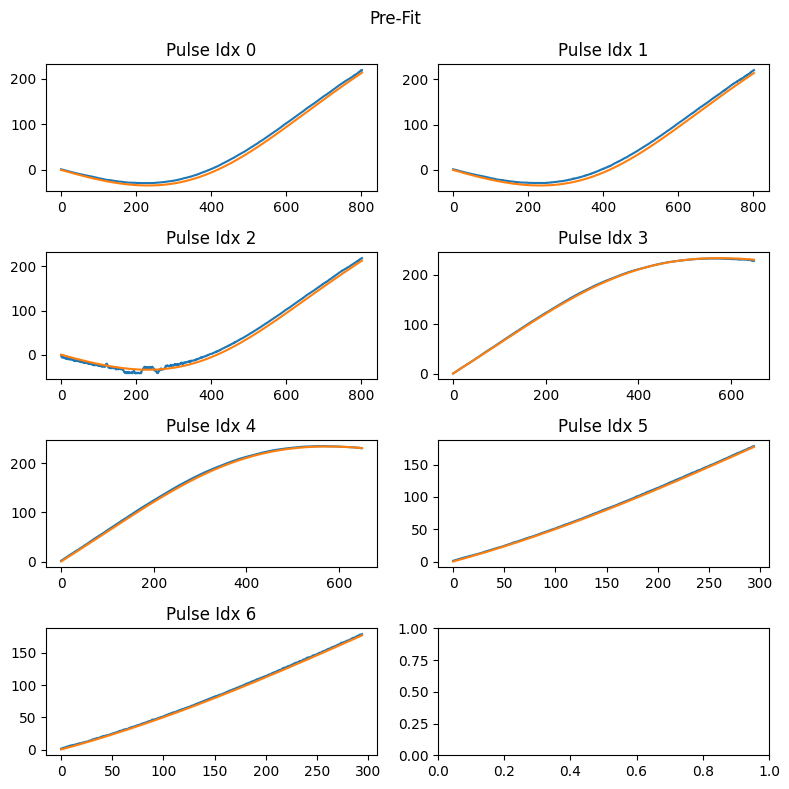

In [57]:
batch = observed_data[:]
batch_num = 0
batch_size

fig, ax = plt.subplots(int(np.ceil(len(batch)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit")
for pulse_idx in range(len(batch)):
    adjusted = pulse_idx + batch_num*batch_size
    print(adjusted)
    predicted_data = ch.phase_pred(a2_coords, adjusted, info, context)
    ax[pulse_idx].set_title(f"Pulse Idx {adjusted}")
    ax[pulse_idx].plot(batch[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

SAVE ALL THE PULSES

In [10]:
#convention is that main group name is the start of the total thing, i.e. global start time
#and then the name of the visibility is for each pulse, the start time of the pulse (wrt global start time) with the channel after.


with h5py.File(f'vis_all_{global_start_time}_10hrs.h5', 'a') as f:
    for pulse_idx, observed in enumerate(observed_data):
        satID = info[pulse_idx][1]
        offset = info[pulse_idx][3]
        chan = info[pulse_idx][2]
        start_time = info[pulse_idx][0][0]
        end_time = info[pulse_idx][0][1]
        
        pulse_array = f.create_dataset(f'{start_time}_{chan}', data=observed)
        pulse_array.attrs['pulse_info'] = [start_time, end_time, satID, chan, offset]


In [11]:
observed_data = []
info = []

with h5py.File(f'vis_all_{global_start_time}_10hrs.h5', 'r') as f:
    for pulse in f:

        # Access a dataset
        print(pulse)
        p = f[f'/{pulse}'].attrs['pulse_info']
        pulse_info = [[int(p[0]), int(p[1])], int(p[2]), int(p[3]), int(p[4])]
        info.append(pulse_info)
        data = f[f'/{pulse}'][:]
        observed_data.append(data)
print(info)
print(len(info))

#possible to-do here is to order them by start time. but might not really matter.

12925_1841
13600_1849
13600_1850
14150_1836
14150_1837
14870_1836
14870_1837
17330_1836
17330_1837
18935_1841
19660_1849
19660_1850
20155_1836
20155_1837
20155_1850
20885_1836
20885_1837
2110_1836
2110_1837
26265_1836
26265_1837
26265_1850
26905_1836
26905_1837
29455_1836
29455_1837
30935_1841
30935_1846
31790_1850
32350_1836
32350_1837
32920_1836
32920_1837
32920_1838
35515_1836
35515_1837
6920_1841
8135_1836
8135_1837
[[[12925, 13380], 25338, 1841, 79705], [[13600, 13905], 33591, 1849, 79730], [[13600, 13905], 33591, 1850, 79705], [[14150, 14695], 59051, 1836, 79731], [[14150, 14695], 59051, 1837, 79731], [[14870, 15215], 57166, 1836, 79731], [[14870, 15215], 57166, 1837, 79731], [[17330, 17605], 28654, 1836, 79705], [[17330, 17605], 28654, 1837, 79730], [[18935, 19455], 25338, 1841, 103131], [[19660, 20125], 33591, 1849, 79756], [[19660, 20125], 33591, 1850, 79705], [[20155, 20695], 59051, 1836, 79730], [[20155, 20695], 59051, 1837, 79731], [[20155, 20695], 59051, 1850, 81129], [[20

FITTING PART

In [16]:
fit_trf_og = ch.fitting_all(observed_data, [79.41721666666666, -90.75885, 183], ch.phase_pred, good_info, context)[0]

catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #5

In [18]:
ch.distance_calculator(a2_coords, fit_trf_og)

(1.165280599078356, 7.4373478289018635)

In [29]:
fitted_trf = []
#fitted_trf.append(fitted_trf_og)

for coords in fuzzed_coords:
    print(coords)
    single_fit = ch.fitting_all(observed_data, coords, ch.phase_pred, good_info, context, method='trf')[0]
    fitted_trf.append(single_fit)

print(fitted_trf)

[79.41718332787713, -90.75872831881038, 168.80057472722063]
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12

In [43]:
fit_trf_og = ch.fitting_all(observed_data, a2_coords, phase_pred, good_info)[0]
fit_lm_og = ch.fitting_all(observed_data, a2_coords, phase_pred, good_info, method = 'lm')[0]

catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #5

In [57]:
ch.distance_calculator(a2_coords, fitted_coords_trf)

(3.7107812397936204, 7.524711689204253)

In [ ]:
fig, ax = plt.subplots(int(np.ceil(len(observed_data)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Post-Fit")
for pulse_idx in range(len(observed_data)):
    print(pulse_idx)
    predicted_data = phase_pred(a2_coords, info, pulse_idx)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(observed_data[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC


Text(0.5, 1.0, 'Post-Fit')

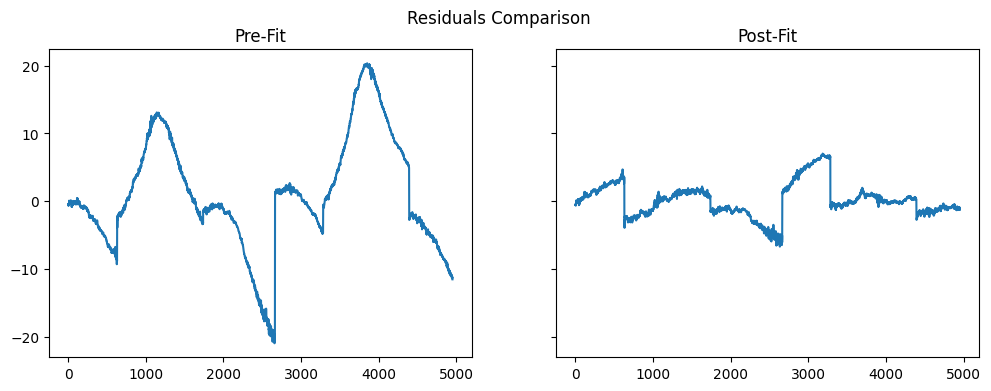

In [45]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.set_size_inches(12, 4)
ax = ax.flatten()
fig.suptitle("Residuals Comparison")  #add start time into title!!
ax[0].plot(ch.residuals_all(a2_coords, observed_data, phase_pred, info))
ax[0].set_title("Pre-Fit")
ax[1].plot(ch.residuals_all(fitted_coords_trf, observed_data, phase_pred, info))
ax[1].set_title("Post-Fit")


catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC


Text(0.5, 1.0, 'LM')

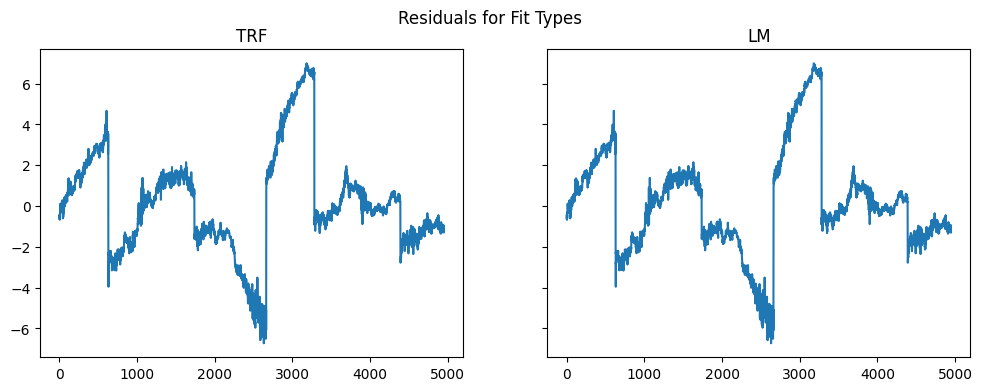

In [46]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.set_size_inches(12, 4)
ax = ax.flatten()
fig.suptitle("Residuals for Fit Types")  #add start time into title!!
ax[0].plot(ch.residuals_all(fitted_coords_trf, observed_data, phase_pred, info))
ax[0].set_title("TRF")
ax[1].plot(ch.residuals_all(fitted_coords_lm, observed_data, phase_pred, info))
ax[1].set_title("LM")


catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC


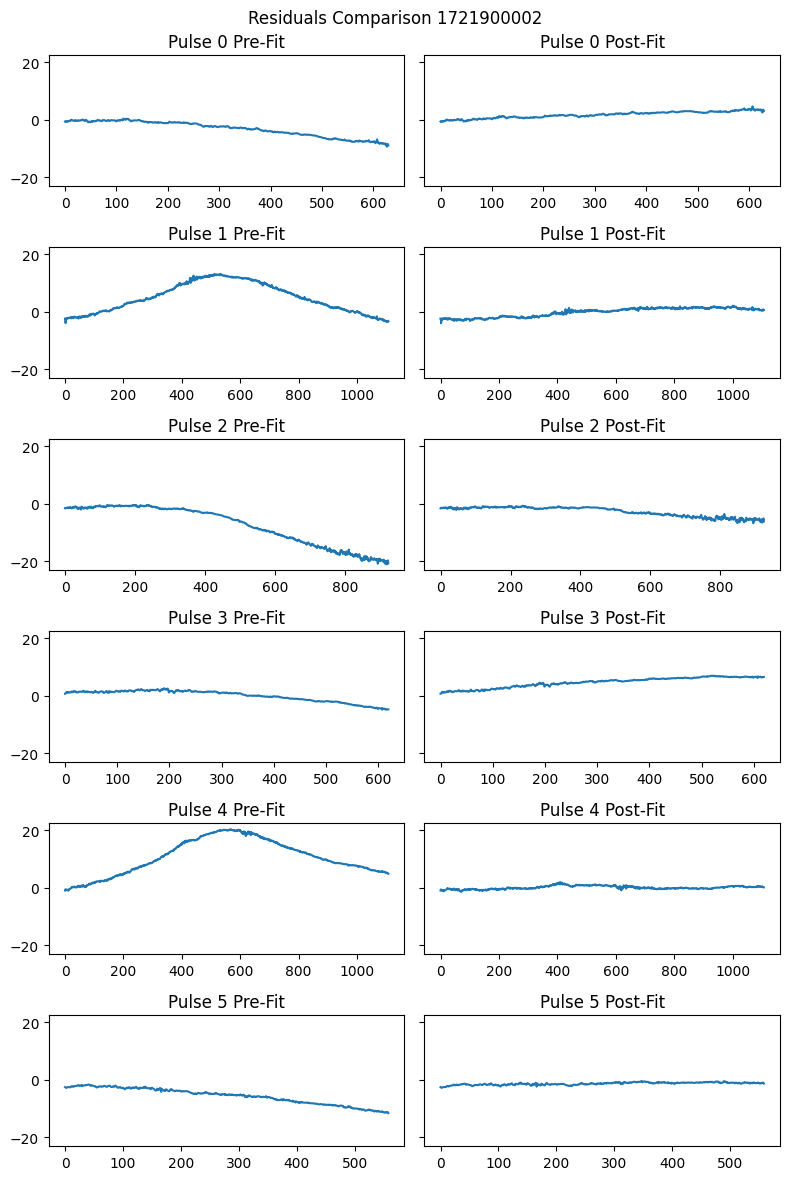

In [48]:
fig, ax = plt.subplots(len(observed_data),2, sharey=True)
fig.set_size_inches(8, 12)
ax = ax.flatten()
fig.suptitle(f"Residuals Comparison {global_start_time}")
for i in range(len(observed_data)):  

    ax[2*i].plot(ch.residuals_individual(a2_coords, observed_data, phase_pred, info, i))
    ax[2*i].set_title(f"Pulse {i} Pre-Fit")

    ax[2*i +1].plot(ch.residuals_individual(fitted_coords_trf, observed_data, phase_pred, info, i))
    ax[2*i +1].set_title(f"Pulse {i} Post-Fit")

fig.tight_layout()

#fig.savefig(path.join(out_path,f"residuals_coordfit_{global_start_time}.jpg"))
#print("saved residual plot to:", path.join(out_path,f"residuals_coordfit_{global_start_time}.jpg"))


catalog #28654 epoch 2024-07-25 20:44:12 UTC


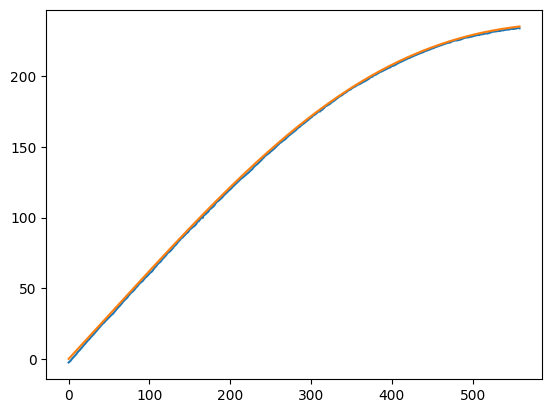

In [50]:
idx = 5

plt.plot(observed_data[idx])

#plt.plot(phase_pred(a2_coords, info, idx))
plt.plot(phase_pred(fitted_coords_trf, info, idx))

In [64]:
print(a2_coords)
print(fitted_coords_trf)
print(coords_idx5)
print(len(observed_data))

[79.41721666666666, -90.75885, 176]
[ 79.41722658 -90.75901238 183.92610356]
[ 79.41718199 -90.76804287 205.25924637]
7
